# Proyek Akhir : Image Classification Model Deployment
- Nama: Kurniati Laeli Munifah
- Email: k.laelimunifah@gmail.com
- Id Dicoding: klmunifah

## Impor dan Pemrosesan Awal Dataset
Dataset yang digunakan adalah dataset Garbage dataset (https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2). File gambar berformat JPG dengan jumlah pixel yang bervariasi. Dari keseluruhan dataset, hanya 3 kategori yang digunakan yaitu cardboards, clothes, dan plastic. Ketiga kategori tersebut membetuk dataset baru berisi 10208 gambar. Dataset disimpan dalam google drive pribadi (MyDrive) bernama image_dataset.zip (https://drive.google.com/file/d/1sNTuEE9Ize2wVw7IXrlTTuNZjA4mAQ2G/view?usp=sharing) . Dataset kemudian diekstrak dengan fungsi mount dan extractall zipfile. Setelah berhasil diekstraksi, dataset kemudian disimpan dalam variable base_dir.

In [3]:
# import library yang digunakan
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import zipfile,os
from google.colab import drive

In [2]:
# melakukan ekstraksi pada file zip
drive.mount('/content/drive/')
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/image_dataset.zip", 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

Mounted at /content/drive/


In [6]:
base_dir = '/content/dataset'

## Pemrosesan lanjutan gambar
Tahap selanjutnya dilakukan penyiapan data train dan data validation menggunakan ImageDataGenerator. Parameter pada ImageDataGenerator bertujuan untuk proses augmentasi gambar. Parameter yang diatur ulang adalah rescale dimana nilai pada gambar yang berada pada rentang 0-255 akan dibagi 255 agar nilainya berada pada rentang 0-1. Selain itu parameter validation_split akan membagi data secara acak menjadi subset training dan validation. Pada proyek ini dibagi menjadi 80% data training dan 20% data validation, sehingga parameter validation_split diatur menjadi 0.4. Pada data training dilakukan proses augmentasi tambahan seperti pengaturan rotation range, width shift range, shear range, zoom range, vertical flip, dan fill_mode.




In [4]:
# Augmentasi dataset
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split = 0.2
)

validation_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split = 0.2
)

Data latih dan data validasi kemudian di load menggunakan fungsi flow_from_directory() agar dapat disimpan ke dalam memori. Target size diatur dengan ukuran 240x160 piksel, dengan menggunakan class_mode 'sparse' karna merupakan data yang dibagi menjadi 3 class yang bernilai integer.
untuk load data training harus menyertakan parameter subset 'training', sedangkan untuk data validation harus menyertakan parameter subset 'validation'.
Dapat dilihat bahwa terdapat 3 kelas pada masing masing 8167 data training dan 2041 data validation.

In [8]:
# Membagi data menjadi data training dan data validation
train_generator = train_datagen.flow_from_directory(base_dir, subset= 'training',
                                                    class_mode='sparse',
                                                    target_size=(240, 160))


validation_generator = validation_datagen.flow_from_directory(base_dir, subset= 'validation',
                                                        class_mode='sparse',
                                                        target_size=(240, 160))

Found 8167 images belonging to 3 classes.
Found 2041 images belonging to 3 classes.


## Membuat dan Menguji Model
Model ini berisi layer input yang akan masuk ke fungsi konvolusi 2D conv2D() dengan parameter berupa 64 bit, matriks konvolusi 3x2 dengan mode aktivasi relu, dan input RGB berukuran 240x160. Model dibuat dengan beberapa layer Convo2D, MaxPooling2D bergantian lalu ditambah layer Flatten serta layer Dense dan Dropout secara bergantian.

Setelah model berhasil dibuat, model kemudian dicompile dengan menggunakan fungsi loss sparse categorical Crossentropy karena model multiclass categorical. Optimizer yang digunakan adalah Adam dengan learning rate 1e-4.

Selanjutnya model ML dilatih dengan menggunakan fungsi fit sebanyak 50 kali epoch. Fungsi fit ini akan berhenti karena adanya Callback sudah mencapai accuracy training dan accuracy validation di atas 93%.
Model fit ini disimpan dalam variable history sehingga dapat ditampilkan dalam sebuah grafik Accuracy dan Loss dari data training dan data validation menggunakan library matplotlib.

In [9]:
# Membuat model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,2), activation='relu', input_shape=(240, 160, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256,(3,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512,(3,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(1024,(3,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 159, 64)      1216      
                                                                 
 max_pooling2d (MaxPooling2  (None, 119, 79, 64)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 78, 128)      49280     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 58, 39, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 38, 256)       196864    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 19, 256)       0

In [11]:
# Mengcompile model
int_lr = 1e-4

optimizer = tf.optimizers.Adam(learning_rate=int_lr)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# Membuat class callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.93 and logs.get('val_accuracy')>0.93):
      print("Akurasi dari model lebih dari 92%")
      self.model.stop_training = True
callbacks = myCallback()

In [13]:
# Melatih model
history = model.fit(train_generator,
              epochs=50,
              validation_data=validation_generator, callbacks=[callbacks])

Epoch 1/50
256/256 [==============================] - 129s 461ms/step - loss: 0.9276 - accuracy: 0.5425 - val_loss: 0.8424 - val_accuracy: 0.5948
Epoch 2/50
256/256 [==============================] - 113s 440ms/step - loss: 0.7935 - accuracy: 0.6349 - val_loss: 0.7406 - val_accuracy: 0.6507
Epoch 3/50
256/256 [==============================] - 115s 450ms/step - loss: 0.7093 - accuracy: 0.6848 - val_loss: 0.5923 - val_accuracy: 0.7580
Epoch 4/50
256/256 [==============================] - 115s 450ms/step - loss: 0.6145 - accuracy: 0.7501 - val_loss: 0.5318 - val_accuracy: 0.7805
Epoch 5/50
256/256 [==============================] - 115s 449ms/step - loss: 0.5495 - accuracy: 0.7849 - val_loss: 0.5567 - val_accuracy: 0.7756
Epoch 6/50
256/256 [==============================] - 115s 450ms/step - loss: 0.5131 - accuracy: 0.8053 - val_loss: 0.4643 - val_accuracy: 0.8217
Epoch 7/50
256/256 [==============================] - 113s 443ms/step - loss: 0.4832 - accuracy: 0.8130 - val_loss: 0.4585 -

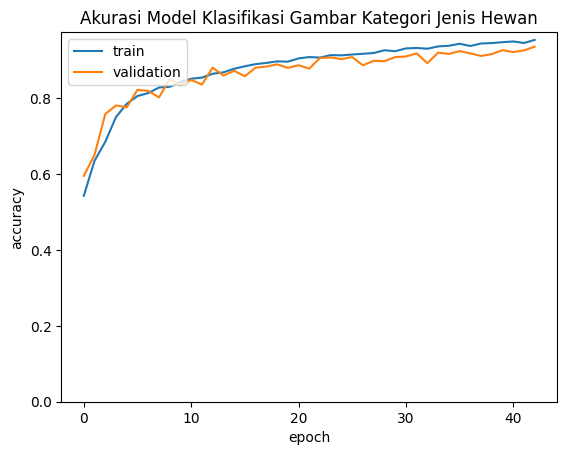

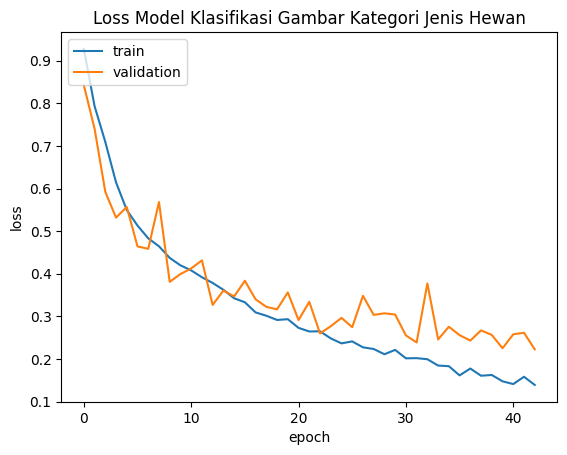

In [14]:
# Grafik

# Grafik Akurasi
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model Klasifikasi Gambar Kategori Jenis Hewan')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(ymin=0)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Grafik Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model Klasifikasi Gambar Kategori Jenis Hewan')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Menyimpan model ke format tftlite
Setelah performa model dirasa cukup, model disimpan dalam format SavedModel. Setelah itu, SavedModel diubah menjadi tflite model

In [15]:
# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi model.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

103411360